# Machine Learning Classification Project: Wine Quality Prediction
## Decision Trees, Random Forests, Feature Transformations & Scaling

In this project, I used a decision tree as well as a random forest for a classification task: classifiying the quality of a wine variant based on its measured qualities.
The dataset used can be found below:

https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

In this project, the **target variable** is **Quality**, which after some adjustment, will take on two classes: good, or bad.

The predictors used are all continuous variables: <br>
_Fixed acidity_, _volatile acidity_, _citric acid_, _residual sugar_, _chlorides_, _free sulfur dioxide_, _total sulfur dioxide_, _density_, _pH_, _sulphates_ and _alcohol_.

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv('winequality-red.csv')

In [6]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Because our target variable in the unadjusted data is numerical - ranging from 3 to 8 - we will change it to a categorical variable for the purpose of this project. <br>
If the wine's quality is a 6 or higher (above the average for the wines in this dataset), it will be considered 'good'; otherwise, it will be considered 'bad'.

In [7]:
# Map continuous target variable to categorical variable
winemap = {3:'bad', 4:'bad', 5:'bad', 6:'good', 7:'good', 8:'good'}
data['quality'] = data['quality'].map(winemap)

In [13]:
# Divide data into training data and test data
wine_tr = data.iloc[0:1200,:]
X_test = data.iloc[1200:, 0:-1]
y_test = data.iloc[1200:, -1]

print(wine_tr.shape)
print(X_test.shape)

(1200, 12)
(399, 11)


In [14]:
# Split data into X and y
X = wine_tr.loc[:, wine_tr.columns != 'quality']
y = wine_tr.loc[:, 'quality']

print(X.shape)
print(y.shape)

(1200, 11)
(1200,)


#### Feature Transformation

Although tree-based methods are not nearly as sensitive to feature distributions as regression-based methods, it is generally good practice to make sure all features in a predictive model follow a generally normal distribution. <br>
We can first examine the original feature distributions in this data, and then based on their skew, we can transform features as needed.

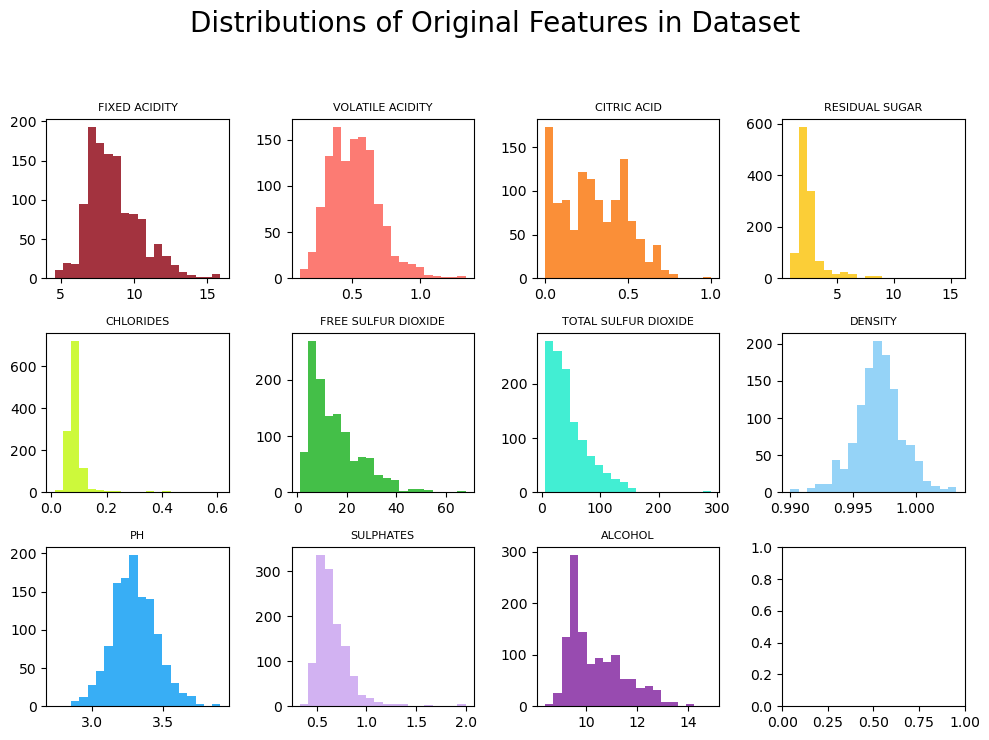

In [15]:
%matplotlib inline

fig, axes = plt.subplots(3, 4, figsize=(10, 7), dpi=100)

colors = ['xkcd:crimson','xkcd:coral','xkcd:orange','xkcd:goldenrod','xkcd:chartreuse', \
          'xkcd:green','xkcd:aqua', 'xkcd:lightblue','xkcd:azure','xkcd:lavender',\
          'xkcd:purple']

for ax, feat, col in zip(axes.flatten(), X.columns, colors):
    x = X[feat]
    ax.hist(x, alpha=0.8, bins=20, stacked=True,label=str(feat), color=col)
    ax.set_title(feat.upper(), fontsize = 8)
            
plt.suptitle('Distributions of Original Features in Dataset', fontsize = 20,y=1.05)
plt.tight_layout()

plt.show()

In the histograms above, one can see that most of the features are skewed. In fact, the only features whose histograms resemble a normal distribution are 'density' and 'pH'. The rest of the features appear to be right-skewed. <br>
After some experimentation, it appears that a log transformation makes the distributions of most of the skewed features closer to normal. For the rest, a square root transformation does the job well.

In [21]:
feats_norm = ['density','pH']
feats_skewed_log = ['fixed acidity','free sulfur dioxide','residual sugar',
                    'total sulfur dioxide','volatile acidity','alcohol','citric acid']
feats_skewed_sqrt = [feat for feat in X.columns if feat not in feats_norm + feats_skewed_log]   
feats_all = feats_norm + feats_skewed_log + feats_skewed_sqrt
print(f'Log transformation : {feats_skewed_log}')
print(f'Cubic root transformation : {feats_skewed_sqrt}')

# Transform skewed features in training data
feats_transformed_tr1 = X[feats_skewed_log].transform(lambda x: np.log(x+1))
feats_transformed_tr2 = X[feats_skewed_sqrt].transform(lambda x: x**(1/3))

# Transform skewed features in testing data
feats_transformed_te1 = X_test[feats_skewed_log].transform(lambda x: np.log(x+1))
feats_transformed_te2 = X_test[feats_skewed_sqrt].transform(lambda x: x**(1/3))


# Join transformed data
feats_transformed_tr = pd.concat([X[feats_norm], feats_transformed_tr1, feats_transformed_tr2], axis=1, sort=False)
feats_transformed_te = pd.concat([X_test[feats_norm], feats_transformed_te1, feats_transformed_te2], axis=1, sort=False)

Log transformation : ['fixed acidity', 'free sulfur dioxide', 'residual sugar', 'total sulfur dioxide', 'volatile acidity', 'alcohol', 'citric acid']
Cubic root transformation : ['chlorides', 'sulphates']


In [22]:
feats_transformed_te

,density,pH,fixed acidity,free sulfur dioxide,residual sugar,total sulfur dioxide,volatile acidity,alcohol,citric acid,chlorides,sulphates
1200,0.99458,3.16,2.163323,1.609438,0.916291,2.302585,0.451076,2.379546,0.190620,0.410157,0.814325
1201,0.99419,3.27,2.186051,1.791759,1.064711,2.397895,0.292670,2.501436,0.307485,0.402073,0.814325
1202,0.99516,3.35,2.261763,1.945910,1.029619,2.564949,0.350657,2.541602,0.329304,0.408166,0.883656
1203,0.99878,3.14,2.388763,3.526361,1.916923,4.343805,0.553885,2.341806,0.173953,0.480590,0.819321
1204,0.99534,3.40,2.104134,3.218876,1.131402,3.806662,0.307485,2.484907,0.378436,0.419834,0.947268
...,...,...,...,...,...,...,...,...,...,...,...
1594,0.99490,3.45,1.974081,3.496508,1.098612,3.806662,0.470004,2.442347,0.076961,0.448140,0.833955
1595,0.99512,3.52,1.931521,3.688879,1.163151,3.951244,0.438255,2.501436,0.095310,0.395789,0.912581
1596,0.99574,3.42,1.987874,3.401197,1.193922,3.713572,0.412110,2.484907,0.122218,0.423582,0.908560
1597,0.99547,3.57,1.931521,3.496508,1.098612,3.806662,0.497740,2.415914,0.113329,0.421716,0.892112


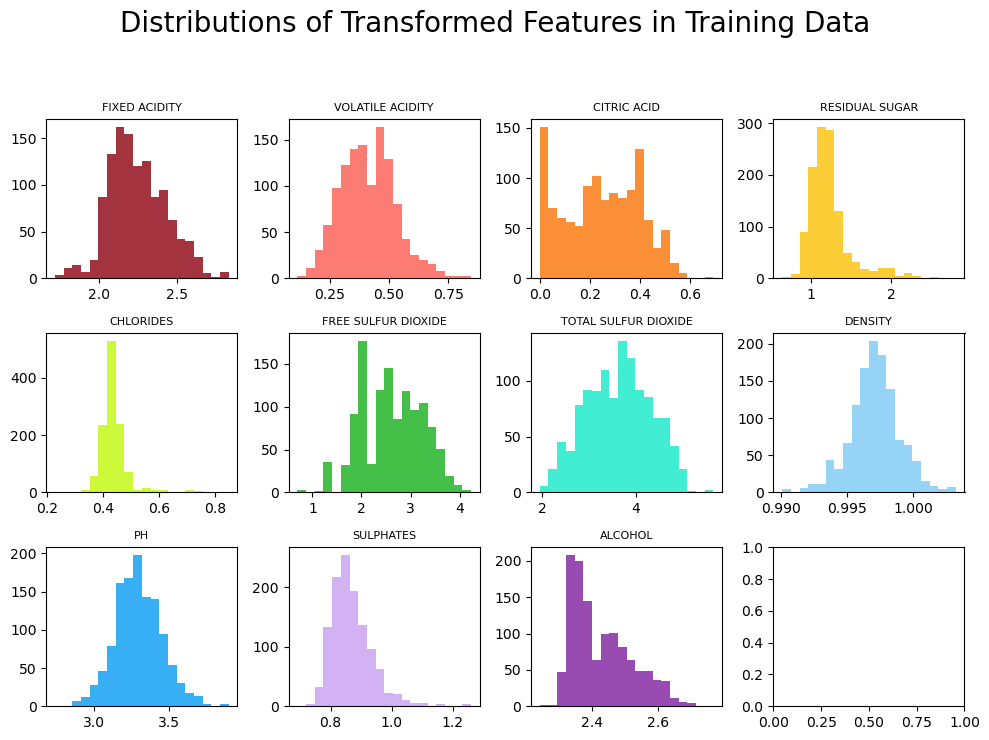

In [23]:
fig, axes = plt.subplots(3, 4, figsize=(10, 7), dpi=100)

colors = ['xkcd:crimson','xkcd:coral','xkcd:orange','xkcd:goldenrod','xkcd:chartreuse', \
          'xkcd:green','xkcd:aqua', 'xkcd:lightblue','xkcd:azure','xkcd:lavender',\
          'xkcd:purple']

for ax, feat, col in zip(axes.flatten(), X.columns, colors):
    x = feats_transformed_tr[feat]
    ax.hist(x, alpha=0.8, bins=20, stacked=True,label=str(feat), color=col)
    ax.set_title(feat.upper(), fontsize = 8)
            
plt.suptitle('Distributions of Transformed Features in Training Data', fontsize = 20, y=1.05)
plt.tight_layout()

plt.show()

The transformations aren't _perfect_ -- there is still abnormality and some skew in some of these features -- but overall, the distributions are closer to normal than before.

Next, we can scale these features so that the absolute scale of each feature's values is the same. Again, this is not completely necessary for tree-based models, but is good practice.

In [24]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit StandardScaler to training data
scaler.fit(feats_transformed_tr)

# Standardize continuous features in training data
X = pd.DataFrame(scaler.transform(feats_transformed_tr),index=feats_transformed_tr.index, columns=feats_all)

# Standardize continuous features in testing data with same fit for consistency
X_test = pd.DataFrame(scaler.transform(feats_transformed_te),index=feats_transformed_te.index, columns=feats_all)

# Confirm DataFrames reconstructed correctly
print(X.shape)
print(X_test.shape)
X

(1200, 11)
(399, 11)


,density,pH,fixed acidity,free sulfur dioxide,residual sugar,total sulfur dioxide,volatile acidity,alcohol,citric acid,chlorides,sulphates
0,0.395190,1.355270,-0.672241,-0.182906,-0.632573,-0.115586,1.034410,-0.927527,-1.609682,-0.294848,-0.637957
1,-0.137716,-0.631256,-0.411388,1.056974,0.194566,0.840060,1.907946,-0.519887,-1.609682,0.397848,0.172368
2,-0.031135,-0.246767,-0.411388,0.278419,-0.138287,0.534766,1.335464,-0.519887,-1.352628,0.220188,-0.020650
3,0.501771,-0.887582,1.420434,0.467294,-0.632573,0.683749,-1.428556,-0.519887,1.304806,-0.329353,-0.495357
4,0.395190,1.355270,-0.672241,-0.182906,-0.632573,-0.115586,1.034410,-0.927527,-1.609682,-0.294848,-0.637957
...,...,...,...,...,...,...,...,...,...,...,...
1195,-0.388182,1.419351,-1.536613,0.789088,-0.766811,0.586160,-0.466742,-0.824166,-0.306406,-0.226736,-0.355997
1196,-0.105742,-0.567174,-0.348028,0.928618,-0.138287,1.321177,0.399041,-0.824166,-0.252903,-0.294848,-0.495357
1197,-1.320769,-0.887582,-0.475473,-1.586799,-1.200339,-1.918162,0.343933,-0.519887,-0.360349,-0.543104,-0.783995
1198,-1.043657,-0.951663,-0.475473,0.636249,-0.502886,1.037476,-1.565244,0.527743,-0.094967,-1.225522,0.835047


In [25]:
# Split training data into training and validation sets
X_train = X.iloc[:900,:]
y_train = y.iloc[:900,]
X_val = X.iloc[900:,:]
y_val = y.iloc[900:,]

#### Decision Tree

First, we can check how well a single decision tree fares in this classification task.

In [39]:
from sklearn.tree import DecisionTreeClassifier

# Train the tree on training data
tree = DecisionTreeClassifier(random_state=20)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=20)

Let's see how well the tree scores on the training data.

In [40]:
# Make predictions on the validation data
y_pred_val = tree.predict(X_val)

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print(f"The tree's accuracy score on the validation data is {accuracy_score(y_val, y_pred_val)*100:.2f}%")
print(f"The tree's precision score on the validation data is {precision_score(y_val, y_pred_val, pos_label='good')*100:.2f}%")
print(f"The tree's recall score on the validation data is {recall_score(y_val, y_pred_val, pos_label='good')*100:.2f}%")

The tree's accuracy score on the validation data is 67.33%
The tree's precision score on the validation data is 79.80%
The tree's recall score on the validation data is 73.97%


0.6167765939455436


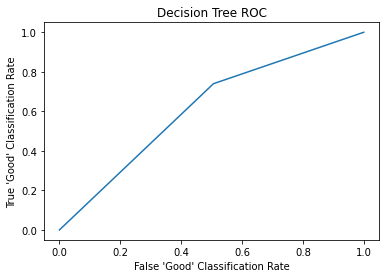

In [42]:
# ROC Curve for Decision Tree on validation data
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

y_val_pred_proba = tree.predict_proba(X_val)[:,1]

fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba, pos_label=tree.classes_[1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlabel("False 'Good' Classification Rate")
plt.ylabel("True 'Good' Classification Rate")
plt.title("Decision Tree ROC")

roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

As one can see from the ROC above, the decision tree does not classify wines very well. The AUC is around .617, which is not far off from .5 (which would mean the model has no capacity to separate classes). <br>
Although some tuning might be able to help this, it might be more practical to first try a random forest instead, and then tune that.

#### Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

# Fit Random Forest on training data
forest = RandomForestClassifier(random_state=20)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=20)

In [44]:
# Make predictions on the validation data
y_pred_val = forest.predict(X_val)

In [45]:
print(f"The random forest's accuracy score on the validation data is {accuracy_score(y_val, y_pred_val)*100:.2f}%")
print(f"The random forest's precision score on the validation data is {precision_score(y_val, y_pred_val, pos_label='good')*100:.2f}%")
print(f"The random forest's recall score on the validation data is {recall_score(y_val, y_pred_val, pos_label='good')*100:.2f}%")

The random forest's accuracy score on the validation data is 76.67%
The random forest's precision score on the validation data is 82.82%
The random forest's recall score on the validation data is 85.84%


AUC value is 0.7895879136366198


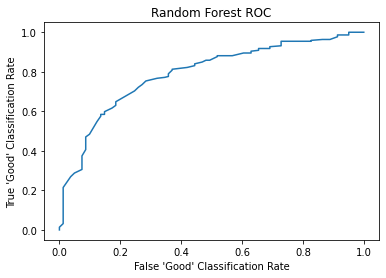

In [46]:
# ROC Curve for untuned Random Forest on validation data
y_val_pred_proba = forest.predict_proba(X_val)[:,1]

fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba, pos_label=forest.classes_[1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlabel("False 'Good' Classification Rate")
plt.ylabel("True 'Good' Classification Rate")
plt.title("Random Forest ROC")

roc_auc = metrics.auc(fpr, tpr)
print(f'AUC value is {roc_auc}')

Already, one can see from the scoring metrics and ROC curve that the Random Forest is much better suited to this classification task than a single tree. The AUC is considerably better - around .79 as opposed to .61. <br>
Of course, an ensemble of trees trained with randomized features and randomly bagged subsets of the training data is more effective at generalizing to unseen data than one decision tree alone.

#### Hyperparameter Tuning

To make sure the random forest fits to the data optimally - neither overfitting to the training data nor underfitting - it's important to make sure that it has an optimal amount of trees, features in each tree, samples in each tree, etc. <br>
It's much easier to investigate this using a GridSearch than trying different hyperparameter combinations manually.

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
# Paramater grid for GridSearch

param_grid = {
    'max_depth': [4,5,6,7,8,9,10],
    'max_features': [3,4,5,6,7,8],
    'min_samples_leaf': [.001,.005,.01,.05,.1,.15,.2],
    'min_samples_split': [.01,.05,.1,.15,.2],
    'n_estimators': [1, 2, 4, 10, 25, 50, 100, 150] 
}

In [49]:
rf = RandomForestClassifier(random_state=20)

In [55]:
from sklearn.model_selection import StratifiedKFold

grid_search = GridSearchCV(estimator = rf, scoring='roc_auc', param_grid = param_grid, 
                          cv = StratifiedKFold(n_splits=3), n_jobs = -1, verbose = 2) 

In [56]:
# Fit the grid search estimator to the training data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 11760 candidates, totalling 35280 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=20), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'max_features': [3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [0.001, 0.005, 0.01, 0.05, 0.1,
                                              0.15, 0.2],
                         'min_samples_split': [0.01, 0.05, 0.1, 0.15, 0.2],
                         'n_estimators': [1, 2, 4, 10, 25, 50, 100, 150]},
             scoring='roc_auc', verbose=2)

In [57]:
# Best parameters:
best_hyperparams = grid_search.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Best hyperparameters:
 {'max_depth': 7, 'max_features': 4, 'min_samples_leaf': 0.001, 'min_samples_split': 0.05, 'n_estimators': 50}


In [58]:
# Best score (AUC):
best_score = grid_search.best_score_
print('Best score:', best_score)

Best score: 0.7973875037783928


In [59]:
# Make predictions on the training set and display accuracy, precision and recall
best_forest = RandomForestClassifier(random_state=20, max_depth=7, max_features=4,\
                                    min_samples_leaf=0.001, min_samples_split=0.05, n_estimators=50)

best_forest.fit(X_train, y_train)

# Make predictions on the validation set and display accuracy, precision and recall. 
y_pred_val = best_forest.predict(X_val)
print(f"The random forest's accuracy score on the validation data is {accuracy_score(y_val, y_pred_val)*100:.2f}%")
print(f"The random forest's precision score on the validation data is {precision_score(y_val, y_pred_val, pos_label='good')*100:.2f}%")
print(f"The random forest's recall score on the validation data is {recall_score(y_val, y_pred_val, pos_label='good')*100:.2f}%")

The random forest's accuracy score on the validation data is 77.67%
The random forest's precision score on the validation data is 83.33%
The random forest's recall score on the validation data is 86.76%


AUC value is 0.7982975365014938


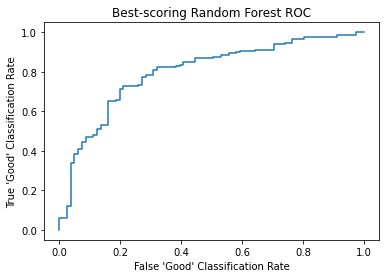

In [60]:
# Using the best model, plot the ROC curve
y_val_pred_proba = best_forest.predict_proba(X_val)[:,1]

fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba, pos_label=best_forest.classes_[1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlabel("False 'Good' Classification Rate")
plt.ylabel("True 'Good' Classification Rate")
plt.title("Best-scoring Random Forest ROC")

roc_auc = metrics.auc(fpr, tpr)
print(f'AUC value is {roc_auc}')

The best combination of hyperparameters in the GridSearch improves the previous AUC by only about 1%, but it's still an improvement.

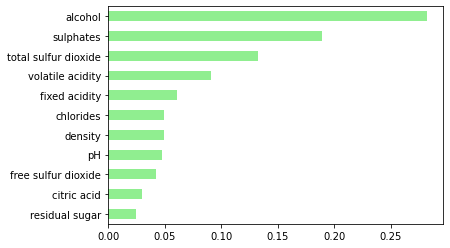

In [61]:
# Feature importances in best model
import pandas as pd
import matplotlib.pyplot as plt
importances = pd.Series(best_forest.feature_importances_, index = X.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='lightgreen')
plt.show()

The random forest's feature importances suggest that the most important features for determining a wine's quality are its ABV, sulphates content, and total sulfur dioxide content.

#### Final model scoring
Now that the best hyperparameters have been found for fitting a random forest to this classification problem, we can see how well the model predicts wine quality on the test data.

In [62]:
# Construct final random forest using best hyperparameters obtained above
final_forest = RandomForestClassifier(random_state=20, max_depth=7, max_features=4,\
                                    min_samples_leaf=0.001, min_samples_split=0.05, n_estimators=50)

final_forest.fit(X, y)

# return the prediction as "y_pred2"
y_pred2 = final_forest.predict(X_test)

In [63]:
# Make predictions on the test set and display accuracy, precision and recall

print(f"The random forest's accuracy score on the test data is {accuracy_score(y_test, y_pred2)*100:.2f}%")
print(f"The random forest's precision score on the test data is {precision_score(y_test, y_pred2, pos_label='good')*100:.2f}%")
print(f"The random forest's recall score on the test data is {recall_score(y_test, y_pred2, pos_label='good')*100:.2f}%")

The random forest's accuracy score on the test data is 75.44%
The random forest's precision score on the test data is 74.34%
The random forest's recall score on the test data is 80.77%


AUC value is 0.8012233185662506


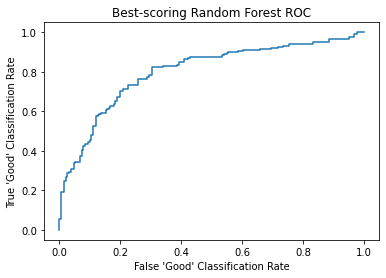

In [64]:
# Using the best model, plot the ROC curve
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
from sklearn import metrics
y_test_pred_proba = final_forest.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba, pos_label=final_forest.classes_[1])
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlabel("False 'Good' Classification Rate")
plt.ylabel("True 'Good' Classification Rate")
plt.title("Best-scoring Random Forest ROC")

roc_auc = metrics.auc(fpr, tpr)
print(f'AUC value is {roc_auc}')

Fortunately, our AUC on the test data is the highest we've seen yet, eclipsing the 0.8 mark. 

Overall, although a wine connoisseur might suggest otherwise, the results in this project positively indicate that a Random Forest can effectively predict the binary quality of a wine from its particular constituents alone. 